# Data
## EDA
### Projects

In [1]:
from collections import Counter
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [2]:
# Load projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (f"{len(projects)} projects")
print (json.dumps(projects[0], indent=2))

955 projects
{
  "id": 6,
  "created_on": "2020-02-20 06:43:18",
  "title": "Comparison between YOLO and RCNN on real world videos",
  "description": "Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.",
  "tag": "computer-vision"
}


In [3]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

955 projects


,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [4]:
# 1. remove projects with no tag
df = df[df.tag.notnull()]

In [5]:
# 2. Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

### Tags

In [6]:
# Load tags
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.json"
tags_dict = {}
for item in json.loads(urlopen(url).read()):
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")


4 tags


In [7]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag="computer-vision"):
    print (json.dumps(tags_dict[tag], indent=2))


interactive(children=(Dropdown(description='tag', options=('computer-vision', 'graph-learning', 'mlops', 'natu…

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

### Tag Distribution

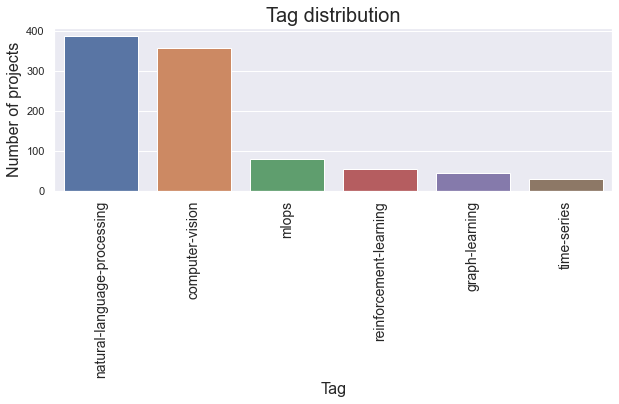

In [9]:
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

### Wordcloud

In [10]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing", column_name = 'title'):
    plt.figure(figsize=(15, 5))
    subset = df[df.tag == tag]
    text = subset[column_name].values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    

interactive(children=(Dropdown(description='tag', options=('natural-language-processing', 'computer-vision', '…

## Data Labeling
- if a data point has a tag that we currently don't support, we'll replace it with `other`
- if a certain tag doesn't have enough samples, we'll replace it with `other`

In [11]:
# Out of scope (OOS) tags 
oos_tags = [item for item in df.tag.unique() if item not in tags_dict.keys()]
oos_tags

['reinforcement-learning', 'time-series']

In [12]:
oos_indices = df[df.tag.isin(oos_tags)].index
df.iloc[oos_indices].head()

,id,created_on,title,description,tag
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning


In [13]:
df.loc[oos_indices, ['tag']] = ["other"]

In [14]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [15]:
min_freq = 75
tags = Counter(df.tag.values)
print(tags)

Counter({'natural-language-processing': 388, 'computer-vision': 356, 'other': 87, 'mlops': 79, 'graph-learning': 45})


In [16]:
@widgets.interact(min_freq=(0, tags.most_common()[0][1]+1))
def separate_tags_by_feq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements() if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements() if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=389), Output()), _dom_classes=('widget-i…

In [17]:
def filter(tag, include=[]):
    """Determine if a given tag is to be included

    Args:
        tag (_type_): _description_
        include (list, optional): _description_. Defaults to [].
    """    
    if tag in include:
        return tag

In [18]:
tags_above_freq = Counter(tag for tag in tags.elements() if tags[tag] >= min_freq)
df.tag = df.tag.apply(filter, include=list(tags_above_freq.keys()))

In [19]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",None
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,None


In [20]:
df.tag = df.tag.fillna("other")

In [21]:
from snorkel.labeling import labeling_function

@labeling_function()
def contains_tensorflow(text):
    condition = any(tag in text.lower() for tag in ("tensorflow", "tf"))
    return "tensorflow" if condition else None

## Preprocessing

### Feature engineering

In [22]:
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other


In [23]:
df['text'] = df.title + " " + df.description

In [24]:
df.head()

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...


### Cleaning

In [25]:
%pip install nltk==3.7 -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python38\python.exe -m pip install --upgrade pip' command.


In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [27]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text

    Args:
        text (str): _description_
        lower (bool, optional): _description_. Defaults to True.
        stem (bool, optional): _description_. Defaults to False.
        stopwords (_type_, optional): _description_. Defaults to STOPWORDS.
    """
    if lower:
        text = text.lower()

    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        # NOTE: above regex \b... searches for "..." at the beginning of a word
        # "...\b" searches for "..." at the end of a word
        # "\s" searches for whitespace characters
        # "*" searches for zero or more occurrences of preceeding text
        text = pattern.sub('', text)
    
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars, "[^...]" - not containing "..."
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])
    
    return text

In [29]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs. 12 #$  ! @.fv ronb wo2in3r"
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)    

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [30]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")


Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Encoding

In [31]:
import numpy as np
import random


In [32]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

In [33]:
X = df.text.to_numpy()
y = df.tag

In [34]:
class LabelEncoder():
    """Encode target labels `y` into unique indices between `0` and `n_classes-1`.
    """
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {} # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
    
    def __len__(self):
        return len(self.classes)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})"
    
    def fit(self, y):
        classes = np.unique(y)
        self.index_to_class = {}
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
            self.index_to_class[i] = class_
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        # A class method is LIKE a static function?
        # A class method is a method which is bound to the class and not the object of the class.
        # They have the access to the state of the class as it takes a class parameter that points to the class and not the object instance.
        # It can modify a class state that would apply across all the instances of the class. For example, it can modify a class variable that would be applicable to all the instances.
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

    

In [35]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)


In [36]:
label_encoder.class_to_index


{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [37]:
label_encoder.index_to_class


{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [38]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])


array([0, 1, 1])

In [39]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))


['computer-vision', 'mlops', 'mlops']

In [40]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)


(955,)


## Splitting

**What are the criteria we should focus on to ensure proper data splits?**
- the dataset (and each data split) should be representative of data we will encounter
- equal distributions of output values across all splits
- shuffle your data if it's organized in a way that prevents input variance
- avoid random shuffles if your task can suffer from data leaks (ex. time-series)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15


In [43]:
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, stratify=y)

In [44]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")


train: 668 (0.70)
remaining: 287 (0.30)


In [45]:
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=(test_size/(test_size+val_size)), stratify=y_)

In [46]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")


train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [49]:
# Get counts for each class
counts = {}
counts["train_counts"] = Counter(label_encoder.decode(y_train))
counts["val_counts"] = Counter(label_encoder.decode(y_val))
counts["test_counts"] = Counter(label_encoder.decode(y_test))


In [51]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,natural-language-processing,computer-vision,mlops,other
train,272,249,55,92
val,58,53,12,20
test,58,54,12,20


In [52]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))


In [53]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df


,natural-language-processing,computer-vision,mlops,other
train,272,249,55,92
val,270,247,56,93
test,270,252,56,93


In [59]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))


0.9851056877051132

In [60]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,talking heads attention variation multi head a...,natural-language-processing
1,leveraging temporal context object detection o...,computer-vision
2,tensorflow 2 meets object detection api tf obj...,computer-vision
3,great expectations always know expect data,mlops
4,torch points3d pytorch framework deep learning...,computer-vision


## Augmentation

In [62]:
!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\soham\\AppData\\Roaming\\Python\\Python38\\site-packages\\~umpy\\.libs\\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll'
Check the permissions.

You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [64]:
import nlpaug.augmenter.word as naw

In [66]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='substitute')
insertion = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='insert')
text = "Conditional image generation using Variational Autoencoders and GANs."


Downloading: 100%|██████████| 268M/268M [03:30<00:00, 1.28MB/s]


In [67]:
# Substitutions
substitution.augment(text)


'hybrid image generation using smart autoencoders 3d printers.'

Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them. Let's try insertion...

In [68]:
# Insertions
insertion.augment(text)


'conditional image sensor generation software using variational autoencoders arrays and spectral gans.'

A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. Maybe instead of substituting or inserting new tokens, let's try simply swapping machine learning related keywords with their aliases from our auxiliary data. We'll use Snorkel's transformation functions to easily achieve this.

In [69]:
def replace_dash(x):
    """Replace dashes from tags & aliases

    Args:
        x (str): _description_
    """
    return x.replace("-", " ")
    

In [71]:
# Create dict of aliases
flat_tags_dict = {}
for tag, info in tags_dict.items():
    tag = replace_dash(x=tag)
    aliases = list(map(replace_dash, info['aliases']))
    if len(aliases):
        flat_tags_dict[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flat_tags_dict[alias] = _aliases

In [72]:
print (flat_tags_dict["natural language processing"])
print (flat_tags_dict["nlp"])


['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [73]:
flat_tags_dict

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'graph learning': ['graphs'],
 'graphs': ['graph learning'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [74]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")


True
True


In [75]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)


In [76]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))


<re.Match object; span=(10, 13), match='gan'>
None


In [77]:
from snorkel.augmentation import transformation_function

In [78]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.

    Args:
        x (_type_): _description_
    """
    matches = []
    text = x.text
    for i, tag in enumerate(flat_tags_dict):
        match = find_word(tag, text)
        if match:
            matches.append(match)
    if len(matches):
        match = random.choice(matches)
        tag = text[match.start(), match.end()]
        x.text = f"{text[:match.start()]}{random.choice(flat_tags_dict[tag])}{text[match.end():]}"
    return x

In [ ]:
# Swap
sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
for i in range(3):
    print (swap_aliases(sample_df.iloc[0]).text)
